# Birdsongs .- 10 - Modelando Datos - Deep Learning CNN


Mediante este notebook, utilizando redes neuronales convolucionales (CNN), bastante eficientes en problemas de clasificación de imágenes, vamos a intentar clasificar un grupo de aves a partir de sus cantos. Los audios han sido convertidos previamente a espectrogramas, que son representaciones de la señal de audio en el dominio del tiempo, para una serie de frecuencias y midiendo el nivel de energía.

Este modelo ha sido adoptado en otros trabajos y competiciones de Kaggle para el reconocimiento de audio, bien sonidos humanos o de otro tipo: ruido ambiente, música, animales, ....

* https://medium.com/@ksusorokina/image-classification-with-convolutional-neural-networks-496815db12a8
* https://spark-in.me/post/bird-voice-recognition-one
* https://www.kdnuggets.com/2017/12/audio-classifier-deep-neural-networks.html


Como framework de deep learning utilizaremos la librería de Keras sobre Tensorflow

Modificando los hiperparámetros y los distintos set de datos, podemos entrenar el modelo hasta conseguir la accuracy más alta posible.

Para entender el funcionamiento de este tipo de algoritmos, podemos visitar este artículo

https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/


![cover](./resources/Cover.png)


El resultado de este notebook es conseguir un modelo lo suficientemente preciso, guardando los parámetros del mejor modelo. Se puede guardar una vez ejecutado como documento HTML para la evaluación conjunta con otros algoritmos o entre diferente set de datos.


## 1.- Librerías

Librerias utilizadas en el notebook


Para el uso de redes neuronales convolucionales utilizaremos Keras sobre Tensorflow
[**keras**](https://keras.io/) 

>Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation. Being able to go from idea to result with the least possible delay is key to doing good research.

      conda install -c conda-forge keras

Para generar la matriz de confusión y el informe de clasificación vamos a utilizar sklearn
[**scikit-learn**](https://scikit-learn.org/stable) 

> A set of python modules for machine learning and data mining

      conda install scikit-learn 
      
Para la visualización de datos vamos a utilizar [**seaborn**](https://seaborn.pydata.org/), que es una librería de visualización basada en matplotlib.


      conda install -c anaconda seaborn       



In [1]:
# importar librerías
import os
import datetime
import json

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from keras.preprocessing import image
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization

import tensorflow as tf

import seaborn as sns

%pylab inline
plt.style.use('seaborn-talk')


Using TensorFlow backend.


Populating the interactive namespace from numpy and matplotlib


## 2.- Funciones

Funciones comunes utilizadas en el notebook

### Dibuja métrica de entrenamiento

Muestra gráfica del entrenamiento del modelo para una métrica determinada

In [2]:
#----------------------------------------------------------------------------
# plot_metric(history, metric)
#  argumentos: 
#      history: diccionario con la historia del modelo
#      metric: tipo de métrica a representar
#----------------------------------------------------------------------------
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    
    plt.figure(figsize=(10,6))
    
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
        
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.show()      
    

### Dibuja matriz de confusión

Muestra en un gráfico la matriz de confusión

In [3]:
#----------------------------------------------------------------------------
# plot_confusion_matrix(ytest, ypred, target_names)
#  argumentos: 
#      ytest: valores reales
#      ypred: valores predichos
#      target_names: nombre de las clases
#----------------------------------------------------------------------------
def plot_confusion_matrix(ytest, ypred, target_names):
    cnf_matrix = confusion_matrix(ytest, ypred)

    plt.figure(figsize=(45,45))

    sns.heatmap(cnf_matrix, square=True, annot=True, fmt='d', cbar=False, 
                xticklabels = target_names,
                yticklabels = target_names,
                cmap=plt.cm.Blues)  

    plt.xlabel('true label')
    plt.ylabel('predicted label')
    plt.show()   


### Dibuja informe de clasificación

Muestra un informe de clasificación con las métricas de precisión, recall, f1-score, ...


In [4]:
#----------------------------------------------------------------------------
# plot_classification_report(ytest, ypred, target_names)
#  argumentos: 
#      ytest: valores reales
#      ypred: valores predichos
#      target_names: nombre de las clases
#----------------------------------------------------------------------------
def plot_classification_report(ytest, ypred, target_names):
    print(classification_report(ytest, ypred,
                                target_names = target_names))  

## 3.- Establece hiperparámetros

Determina los parámetros del modelo que vamos a entrenar

In [5]:
# tamaño de los bloques de imágenes
batch_size = 128

# tamaño de las imágenes
target_size = (200,200)

# número de clases
num_classes = 103

# número de épocas
epochs = 100

# ratio de dropout
droprate = 0.6


## 4.- Prepara imágenes

Keras permite de una manera sencilla tratar las imágenes para que el modelo las entrene a través de   [**ImageDataGenerator**](https://keras.io/preprocessing/image/). Para ello, debemos tener un directorio para cada uno de los sets de Train, Test y Validación, y dentro de estos, las imágenes tienen que estar dentro de un directorio cuyo nombre será la etiqueta de la clase a la que pertenecen:.

    ./model
        /train
            /class1
                picture1
                picture2
                ..
            /class2
                picture1
                picture2
                ..                
        /validation
            


El iterador se encarga de ir leyendo los ficheros de imágenes en bloques, del tamaño que se definan (**batchsize**), convertirlos en datos y reescalarlos.


https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720




In [6]:
# repositorio con los datos del modelo 
base_dir = './model/melall'

# sets de train, validación y test
train_datagen = image.ImageDataGenerator(rescale=1.0/255.0)
test_datagen = image.ImageDataGenerator(rescale=1.0/255.0)
validation_datagen = image.ImageDataGenerator(rescale=1.0/255.0)

train_dir = os.path.join(base_dir, "train")
validation_dir = os.path.join(base_dir, "validation")
test_dir = os.path.join(base_dir, "test")

# train
train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)

# test
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

# validación
validation_gen = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    color_mode="rgb",
    batch_size=batch_size,
    class_mode='categorical'
)


Found 11812 images belonging to 103 classes.
Found 3475 images belonging to 103 classes.
Found 2086 images belonging to 103 classes.


## 5.- Construye el modelo

Definimos la arquitectura de la red neuronal:
* Define el **Número de capas** que forman parte de la red
* Incluye [**Dropout**](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) en las capas densas del modelo
* **Softmax** como última capa de salida, para un problema de clasificación multiclase


In [7]:
# modelo secuencial
m = models.Sequential()

# define capas
m.add(layers.Conv2D(32, (3, 3), input_shape=(200, 200, 3), activation='relu'))
m.add(layers.MaxPooling2D((2,2)))

m.add(layers.Conv2D(64, (3, 3), activation='relu'))
m.add(layers.MaxPooling2D((2,2)))

m.add(layers.Conv2D(128, (3, 3), activation='relu'))
m.add(layers.MaxPooling2D((2,2)))

m.add(layers.Conv2D(128, (3, 3), activation='relu'))
m.add(layers.MaxPooling2D((2,2)))

m.add(layers.Conv2D(128, (3, 3), activation='relu'))
m.add(layers.MaxPooling2D((2,2)))

m.add(layers.Flatten())
m.add(layers.Dense(256, activation='relu'))
m.add(layers.Dropout(droprate))
m.add(layers.Dense(num_classes, activation=tf.nn.softmax))


# muestra descripción del modelo
m.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 97, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 46, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 23, 23, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 21, 21, 128)       147584    
__________

## 6.- Compila el modelo

Compila el modelo, indicando la función de pérdida, el optimizador a utilizar y la métrica.

* **Optimizador**: utilizaremos el recomendado por defecto **rmsprop**
* **Función de pérdida**: al tratarte de un problema de clasificación multiclase, utilizaremos **categorical_crossentropy**
* **Métrica**: utilizaremos **metrics.categorical_accuracy**, que es la específica para este tipo de problemas


In [8]:
m.compile(
    optimizer=optimizers.rmsprop(),
    loss=losses.categorical_crossentropy,
    metrics=[metrics.categorical_accuracy]
)

## 7.- Entrena el modelo

Entrena el modelo en base a los hiperparámetros establecidos. Una vez finalizado el entreno, dibuja las gráficas de la función de pérdida y la precisión, que nos permite visualizar como se está comportando el modelo y reajustar los parámetros para volver a entrenar de nuevo.

Durante el proceso de entreno vamos a utilizar [**callbacks**](https://keras.io/callbacks/)

>A callback is a set of functions to be applied at given stages of the training procedure. You can use callbacks to get a view on internal states and statistics of the model during training. 

Y en concreto estos tres:

* **EarlyStopping**: nos permite configurar una parada automática del modelo si se cumplen unas condiciones determinadas. En nuestro caso, si no mejora el accuracy de la validación tras pasar un número determinado de épocas.

* **ModelCheckpoint**: nos permite salvar los parámetros del modelo con la mejor accuracy en validación. Este sería el modelo a implementar en el entorno productivo.

* **ReduceLROnPlateau**: nos permite reducir la velocidad de aprendizaje cuando el modelo va dejando de mejorar, atendiendo a la función de pérdida.

>Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.



Epoch 1/100
93/93 [==============================] - 84s 899ms/step - loss: 4.4669 - categorical_accuracy: 0.0351 - val_loss: 3.9974 - val_categorical_accuracy: 0.0839
Epoch 2/100
93/93 [==============================] - 79s 849ms/step - loss: 3.8566 - categorical_accuracy: 0.1014 - val_loss: 3.5685 - val_categorical_accuracy: 0.1390
Epoch 3/100
93/93 [==============================] - 79s 845ms/step - loss: 3.4771 - categorical_accuracy: 0.1560 - val_loss: 3.2085 - val_categorical_accuracy: 0.1927
Epoch 4/100
93/93 [==============================] - 79s 844ms/step - loss: 3.2366 - categorical_accuracy: 0.1956 - val_loss: 2.9969 - val_categorical_accuracy: 0.2445
Epoch 5/100
93/93 [==============================] - 79s 845ms/step - loss: 3.0368 - categorical_accuracy: 0.2393 - val_loss: 2.9325 - val_categorical_accuracy: 0.2675
Epoch 6/100
93/93 [==============================] - 78s 835ms/step - loss: 2.8713 - categorical_accuracy: 0.2672 - val_loss: 2.8330 - val_categorical_accuracy:

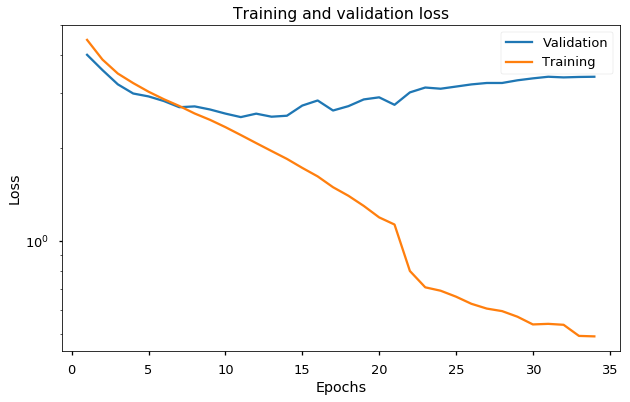

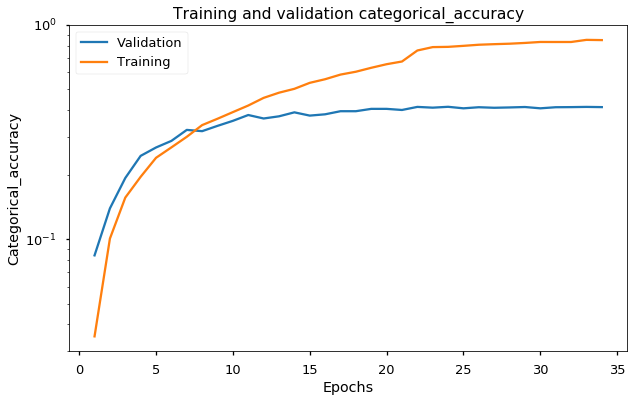

In [9]:
# fichero de salvado del mejor modelo calculado
now = datetime.datetime.now()
model_path = os.path.join(base_dir, 
                          'save', 
                          'birdsongs_model_' + now.strftime("%Y%m%d%H%M%S") + '.hdf5')

checkpoint_dir = os.path.join(base_dir, "save")
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

# configura callbacks
callbacks = [
    EarlyStopping(monitor='val_categorical_accuracy', 
                patience=10,
                mode='max',
                verbose=1),
    ModelCheckpoint(model_path,
                monitor='val_categorical_accuracy', 
                save_best_only=True, 
                mode='max',
                verbose=0),    
    ReduceLROnPlateau(monitor = "val_loss", 
                factor = 0.1, 
                patience = 10,
                verbose = 0, 
                mode = "auto",
                min_delta = 1e-04, 
                cooldown = 0,
                min_lr = 0)   
]

# entrena el modelo
h = m.fit_generator(train_gen, epochs= epochs, callbacks=callbacks, validation_data=validation_gen) 

# dibuja función de pérdida
plot_metric(h, 'loss')    
    
# dibuja accuray
plot_metric(h, 'categorical_accuracy') 
    

## 8.- Evalua el modelo

Una vez entrenado el modelo, procedemos a evaluarlo.

### Herramientas

* Evaluar el modelo contra el set de test. 
* Dibujar la [**matriz de confusión**](https://es.wikipedia.org/wiki/Matriz_de_confusi%C3%B3n)

>A confusion matrix is a technique for summarizing the performance of a classification algorithm.
>
>Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset.
>
>Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making.


     https://towardsdatascience.com/understanding-confusion-matrix-a9ad42dcfd62
     https://data-speaks.luca-d3.com/2018/01/ML-a-tu-alcance-matriz-confusion.html


* Imprimir el [**informe de clasificación**](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html)
> Build a text report showing the main classification metrics

Estas tres herramientas nos permiten estudiar el resultado del modelo, y volver a iterar de nuevo realizando los cambios oportunos, si proceden. 

### Consideraciones a tener en cuenta

Una vez obtenida la accuracy tenemos que profundizar más en el resto de información disponible, ya que por sí sola es una métrica que se queda corta. Tendremos que:

* Determinar si las clases están o no balanceadas
* Comparar el resultado contra otras líneas base más simples, como son el azar o la clase mayoritaria
* Qué accuracy consideramos como buena, si cumple con los objetivos marcados
* Qué impacto tienen los falsos positivos y negativos en términos de costes




28/28 [==============================] - 21s 759ms/step


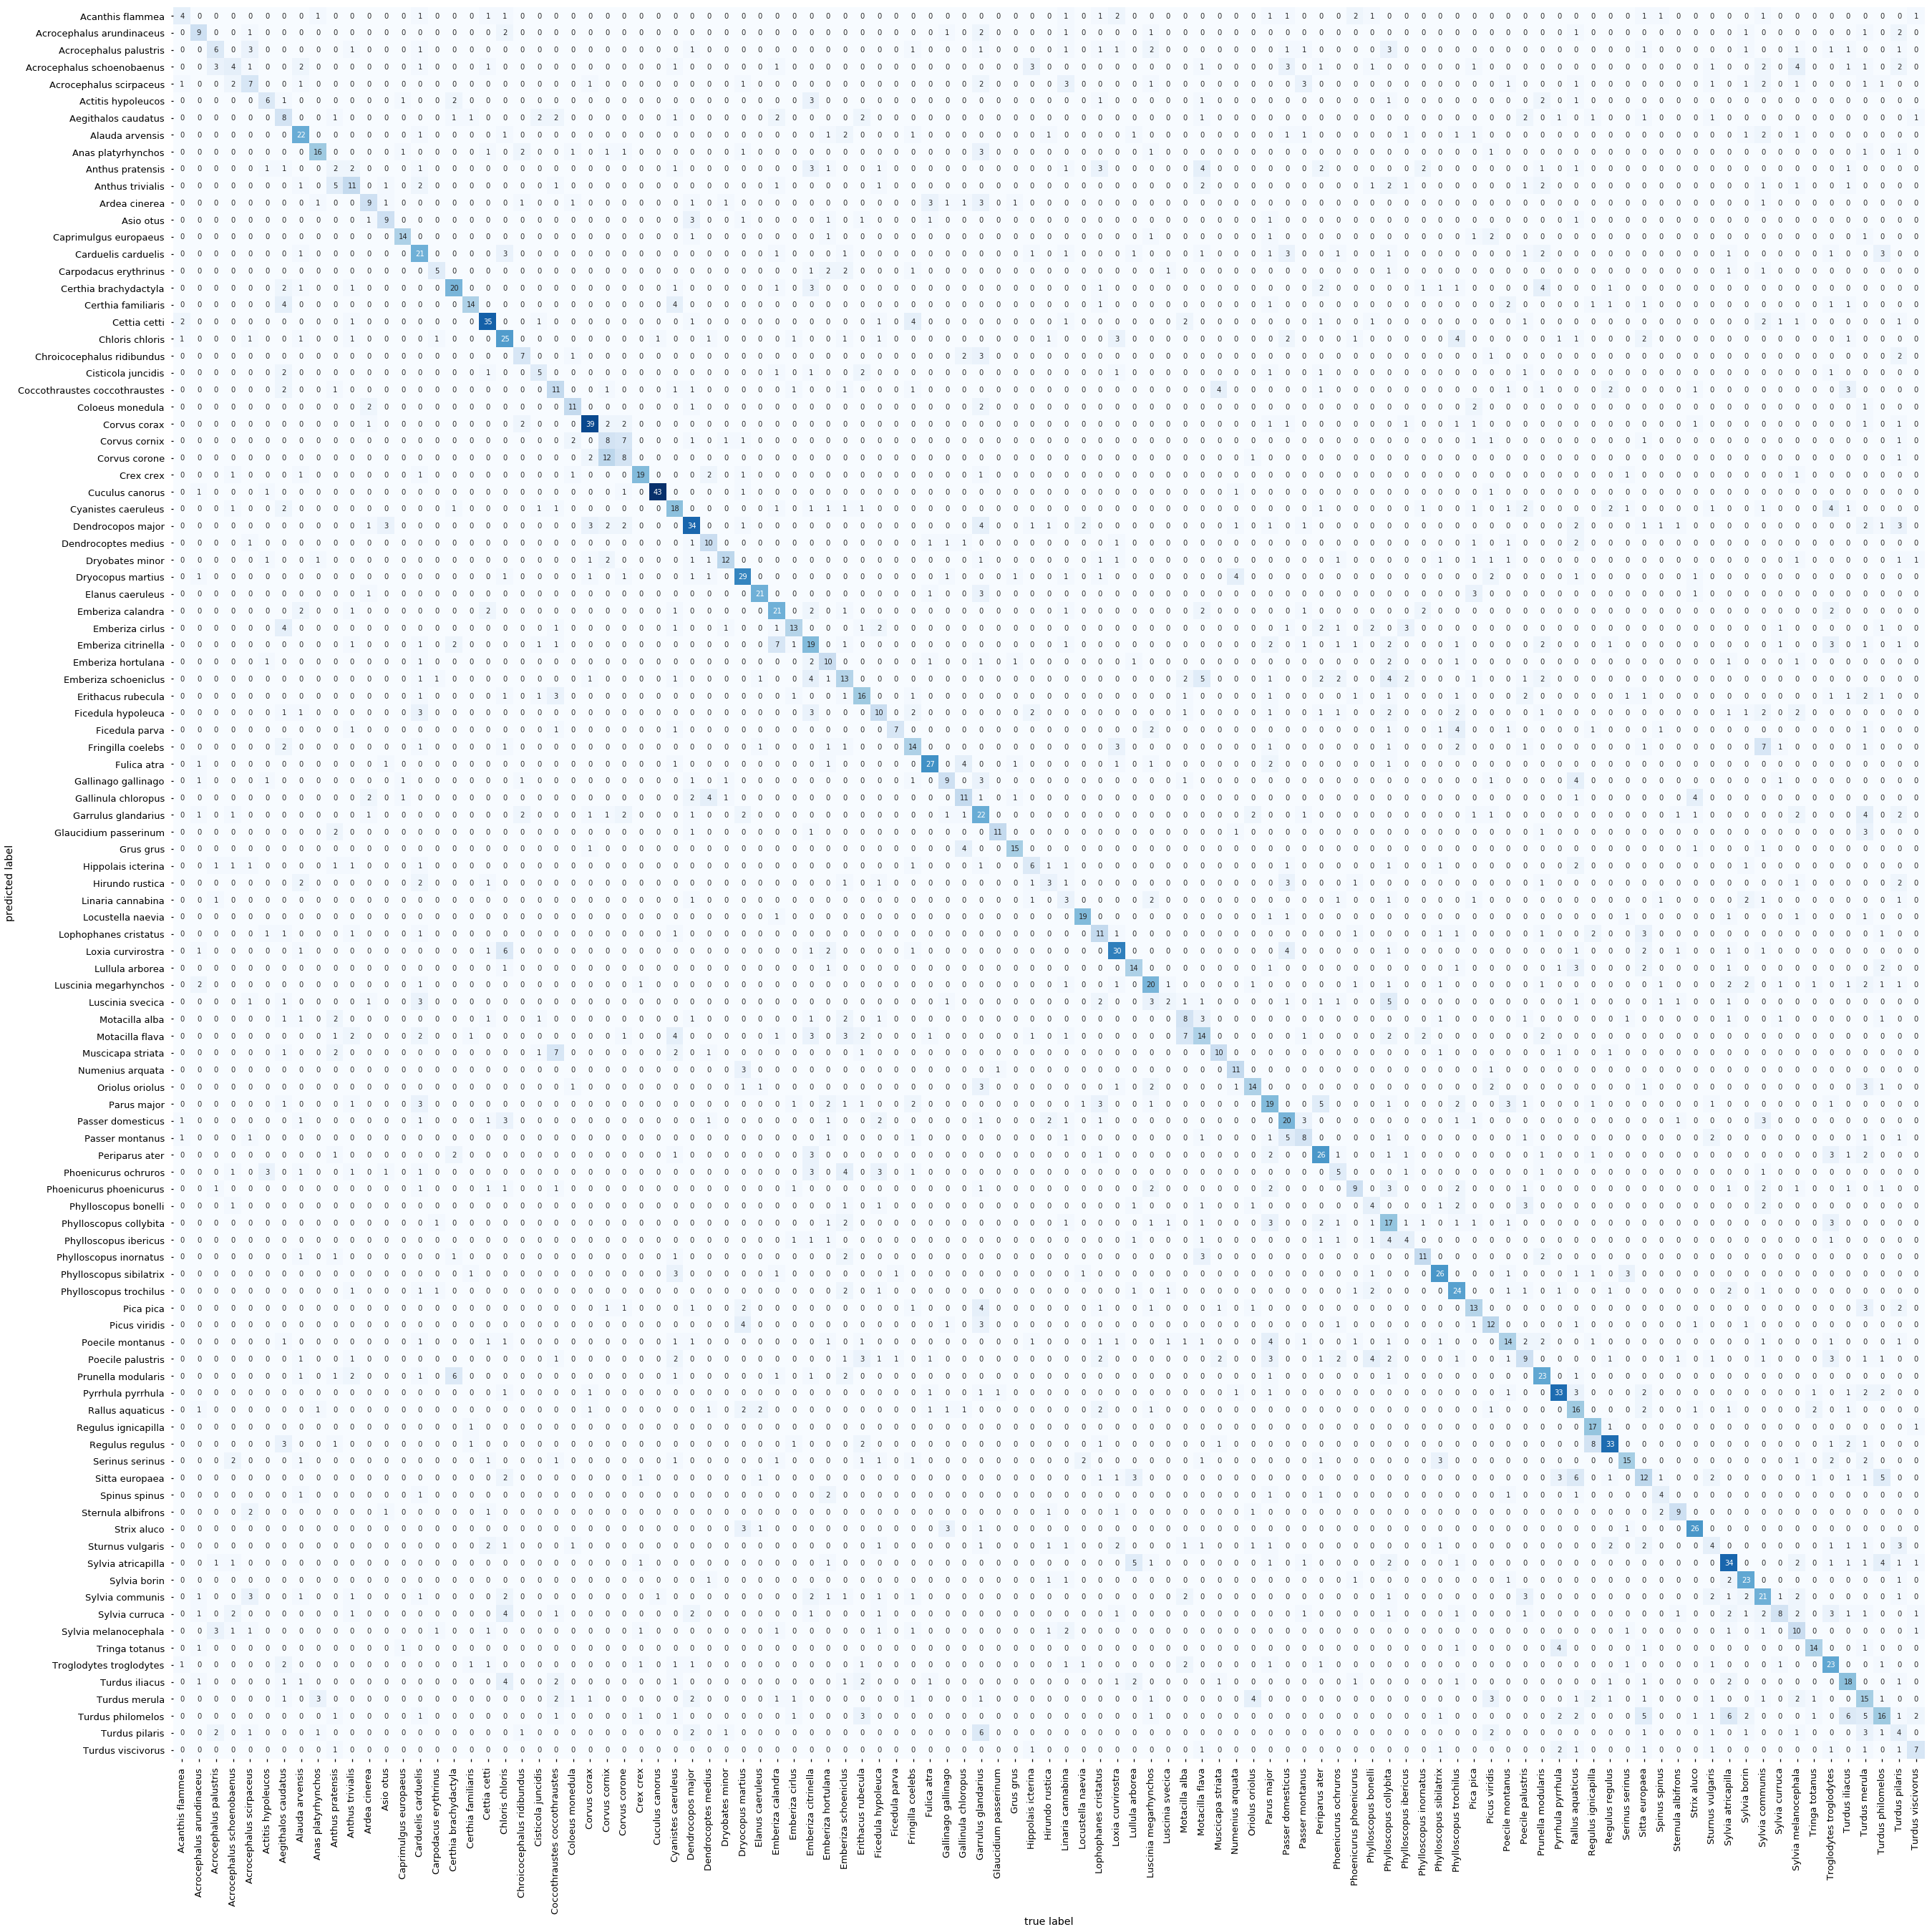

                               precision    recall  f1-score   support

             Acanthis flammea       0.36      0.19      0.25        21
    Acrocephalus arundinaceus       0.41      0.41      0.41        22
       Acrocephalus palustris       0.33      0.20      0.25        30
   Acrocephalus schoenobaenus       0.22      0.11      0.15        35
      Acrocephalus scirpaceus       0.29      0.23      0.25        31
           Actitis hypoleucos       0.40      0.32      0.35        19
          Aegithalos caudatus       0.19      0.29      0.23        28
              Alauda arvensis       0.48      0.56      0.52        39
           Anas platyrhynchos       0.67      0.52      0.58        31
             Anthus pratensis       0.09      0.07      0.08        28
             Anthus trivialis       0.34      0.31      0.33        35
                Ardea cinerea       0.47      0.36      0.41        25
                    Asio otus       0.53      0.47      0.50        19
     

In [10]:
# evalua el modelo contra el set de test
test_gen.reset()
pred = m.predict_generator(test_gen,verbose=1)
predicted_classes = numpy.argmax(pred, axis=1)
true_classes = test_gen.classes
class_labels = list(test_gen.class_indices.keys()) 
   
# dibuja de la matrix de confusión
plot_confusion_matrix(true_classes, predicted_classes, class_labels)
    
# muestra el informe de clasificación
plot_classification_report(true_classes, predicted_classes, class_labels)
